# Brief of the solution ##
 1. Prepare data
 2. Split it to train and test sets
 3. Build regression model with AdaBoostRegressor()
 4. Hyperparameters tuning
 5. Evaluate model
 6. Identifying most valuable features

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import zscore
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('insurance.csv')
print(df.shape)
df.head(5)

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Checking for the missing data and data types #

In [3]:
print('Missing data by columns:')
print(df.isnull().sum())
print()
print('columns dtypes:')
print(df.dtypes)

Missing data by columns:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

columns dtypes:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


# Decoding categorical features  #
 - 'sex' and 'smoker' with LabelEncoder  
 - 'region' with One-Hot encoding (built-in get_dummies() in pandas)

In [4]:
sex_le = LabelEncoder()
df['sex'] = sex_le.fit_transform(df['sex'])

smoker_le = LabelEncoder()
df['smoker'] = smoker_le.fit_transform(df['smoker'])

df = pd.get_dummies(df, prefix='', prefix_sep='')

y = df['charges']
df.drop(['charges'], axis=1, inplace=True)
df['charges'] = y

### Which factors are expected to have the highest impact?

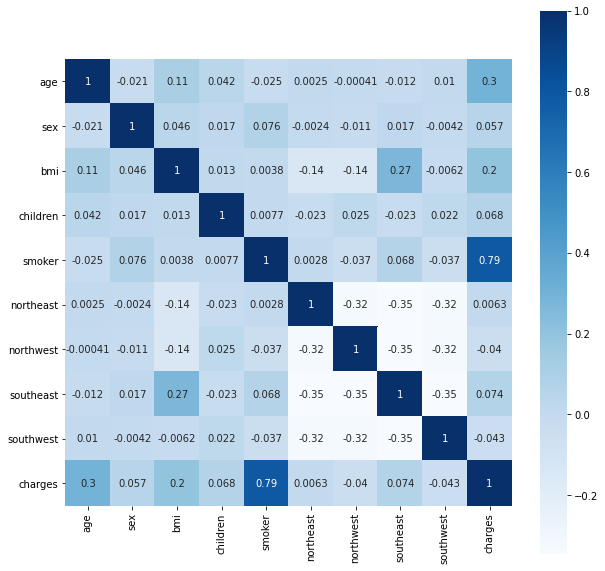

In [5]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True, square=True, cmap='Blues')

#### Expected high 'smoker' impact on target 'charges' (0.79 correlation)####
#### 'age' and 'bmi' also should have high impact on target (0.3 and 0.2 correlation respectively)####

## Find outliers (and delete them if necessary)
Pairplot 'bmi', 'charges' and 'age' with hue='smoker' to find outliers:

<Figure size 720x720 with 0 Axes>

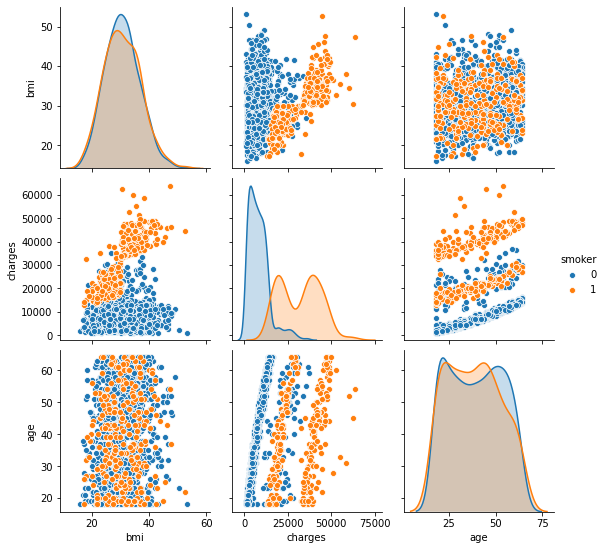

In [6]:
plt.figure(figsize=(10,10))
sns.pairplot(df, vars=['bmi', 'charges', 'age'], hue='smoker', diag_kind='kde')

Seems like there are a few outliers with 'charges' about 50k-70k, so I will drop them using z-score.

removed  29 outliers


<Figure size 720x720 with 0 Axes>

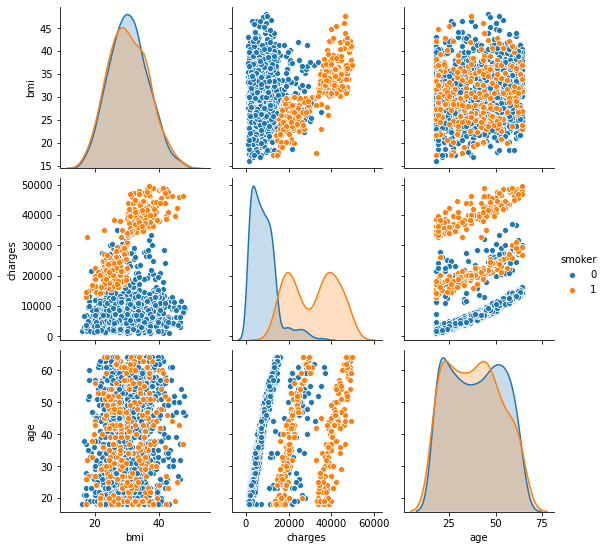

In [7]:
plt.figure(figsize=(10,10))
old_len = df.shape[0]
df = df[(np.abs(zscore(StandardScaler().fit_transform(df))) < 3).all(axis=1)]
print('removed ', old_len-df.shape[0], 'outliers')
sns.pairplot(df, vars=['bmi', 'charges', 'age'], hue='smoker', diag_kind='kde')

Now pairplots are much compact are, which means outliers are dropped.
Distplots are quiet smoother too.

In [8]:
X = df.drop(['charges'], axis=1)
y = df['charges']

# Building regression model  #
 - Split data to train and test set (80% and 20% respectively) 
 - Train baseline model using Linear regression with L2-regularization 
 - Train AdaBoost model and tune its parameteres

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [10]:
baseline = RidgeCV(alphas=[1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10])
baseline.fit(X_train, y_train)
print('baseline train:', r2_score(y_train, baseline.predict(X_train)))
print('baseline test:', r2_score(y_test, baseline.predict(X_test)))

baseline train: 0.7499660001709351
baseline test: 0.7656578837499566


In [11]:
base_adaboost = AdaBoostRegressor()
base_adaboost.fit(X_train, y_train)
print('base adaboost train:', r2_score(y_train, base_adaboost.predict(X_train)))
print('test:', r2_score(y_test, base_adaboost.predict(X_test)))

base adaboost train: 0.8280261239839538
test: 0.834587497007115


In [12]:
#  GridSearchCV with
#  params = {'learning_rate' : [1e-4, 3e-4, 1e-3, 3e-3, 0.01, 0.03, 0.1, 0.3, 0.5, 0.7, 1],
#                              'n_estimators' : [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#                              'base_estimator' : [DecisionTreeRegressor(max_depth=2),
#                                                  DecisionTreeRegressor(max_depth=3),
#                                                  DecisionTreeRegressor(max_depth=5),
#                                                  DecisionTreeRegressor(max_depth=7),
#                                                  DecisionTreeRegressor(max_depth=9),
#                                                  DecisionTreeRegressor(max_depth=2, min_samples_split=3),
#                                                  DecisionTreeRegressor(max_depth=3, min_samples_split=3),
#                                                  DecisionTreeRegressor(max_depth=5, min_samples_split=3),
#                                                  DecisionTreeRegressor(max_depth=7, min_samples_split=3),
#                                                  DecisionTreeRegressor(max_depth=9, min_samples_split=3)]}
#  returns 'learning_rate': 0.001, 'n_estimators': 40, 'max_depth' : 5, 'min_samples_split=3'
#  Then applying GridSearchCV with
#  params = {'learning_rate' : [1e-4, 3e-4, 7e-4, 1e-3, 3e-3, 7e-3, 1e-2, 3e-2, 7e-2, 1e-1],
#            'n_estimators' : np.arange(30, 50, 5),
#            'base_estimator' : [DecisionTreeRegressor(max_depth=4),
#                                DecisionTreeRegressor(max_depth=5),
#                                DecisionTreeRegressor(max_depth=6),
#                                DecisionTreeRegressor(max_depth=4, min_samples_split=3),
#                                DecisionTreeRegressor(max_depth=5, min_samples_split=3),
#                                DecisionTreeRegressor(max_depth=6, min_samples_split=3)]}

# Optimal hyperparameters are 'learning_rate': 0.003, 'n_estimators': 35, 'max_depth'=5, 'min_samples_split=3'

# Example of using GridSearchCV for model with params.
# model = AdaBoostRegressor()
# clf = GridSearchCV(model, params)
# clf.fit(X_train, y_train)
# model = clf.best_estimator_
# print(model)
# print('train:', r2_score(y_train, model.predict(X_train)))
# print('test:', r2_score(y_test, model.predict(X_test)))

In [13]:
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5, min_samples_split=3),
                          n_estimators=35,
                          learning_rate=0.003)
model.fit(X_train, y_train)

r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_test, model.predict(X_test))
rmse_train = np.sqrt(mse(y_train, model.predict(X_train)))
rmse_test = np.sqrt(mse(y_test, model.predict(X_test)))

print('R2 perfomance on train:', r2_train)
print('RMSE perfomance on train:', rmse_train)
print('R2 perfomance on test:', r2_test)
print('RMSE perfomance on test:', rmse_test)

R2 perfomance on train: 0.8779389353534902
RMSE perfomance on train: 4116.438736076583
R2 perfomance on test: 0.8715031565921658
RMSE perfomance on test: 4135.551884048864


I am using R-squared score as metrics because it's clear to understand and interpret.  
R-squared depends on MSE: higher the MSE, smaller the R-squared.  
The closer R-squared to 1, the better model is.  
If model always predicts mean, R-squared is equal to 0.

### Model fits good on train and test set and it hasn't overfit or underfit data. ###
$$ R^2_{train}\approx0.88 \ and\ R^2_{test} \approx 0.87$$

## Most important parameters  in the model##

In [14]:
importances = model.feature_importances_
features = np.argsort(importances)[::-1]
for f in features:
    feature = "'" + X.columns[f] + "'"
    #f-strings (for python 3.6+)
    print(f"feature {feature:10s}\timpact = {importances[f]:.6f}")
    #compatible with any python version
    #print("feature %-10s\timpact=%.6f"%(feature,importances[f]))

feature 'smoker'  	impact = 0.683749
feature 'bmi'     	impact = 0.171389
feature 'age'     	impact = 0.129867
feature 'children'	impact = 0.010238
feature 'northeast'	impact = 0.002225
feature 'northwest'	impact = 0.001130
feature 'southeast'	impact = 0.001059
feature 'sex'     	impact = 0.000312
feature 'southwest'	impact = 0.000031


### As expected, 'smoker', 'bmi' and 'age' have significant impact on 'charges'. ###